In [1]:
from __future__ import print_function
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.tri as mtri
#%matplotlib inline
from matplotlib import colors
from IPython import display
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.graph_objs as go
from plotly.graph_objs import Scatter, Figure, Layout

import tensorflow as tf
from poisson import *
from fun1d import *
# from synGAN import *

/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning:

Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.



In [2]:
# sample data from differenct constant possion distribution

# # initialize parameters
# n = 2**10
# m = 2
# l = 0.005
# pi = math.pi
# max_err = 1e-8
# max_epoch = 1
# epsilon = 1e-4
# optim_pars = [max_err, max_epoch]

# # define filters
# sigma = determine_sigma(epsilon)
# Q = 1
# alpha = 2
# # J = determine_J(n, Q, sigma, alpha)
# J = 7
# s = np.unique(np.floor(2 ** np.linspace(0, J, int(J*Q)+1)))
# # xi = np.arange(1,3) * pi / 3
# nxi = 2
# xi = np.random.choice(n, nxi) * pi / n
# g, g_hat = gabor_wave_family_1d(n, s, xi, sigma)

# n_wave = g_hat.shape[1]*g_hat.shape[2]

# x_dim = n
# ndata = 60000

# sx_dim = 1 + n_wave + n_wave**2 # zero + 1st + 2nd order
# t = np.linspace(0, x_dim + 1, x_dim + 1)
# mu = 1
# x_data = np.zeros((ndata, x_dim)) # signals
# sx_data = np.zeros((ndata, sx_dim)) # scattering coefficients
# y_data = np.zeros((ndata, 10)) # labels(for lambda)


# for i in range(ndata):
#     j = np.random.choice(10,1)
#     lamb = l * (j + 1)
#     x = sample_compound_poisson(t, lamb,'const',mu)
#     x_data[i,:] = np.diff(x)
#     sx = scat_infreq_1d(x_data[i,:], g_hat, m)
#     sx_data[i,:] = np.asarray([sx[0]] + list(sx[1]) + list(sx[2].flatten()))
#     y_data[i,j] = 1
# np.save('x_data', x_data)
# np.save('sx_data', sx_data)
# np.save('y_data', y_data)
x_data = np.load('x_data.npy')
sx_data = np.load('sx_data.npy')
y_data = np.load('y_data.npy')

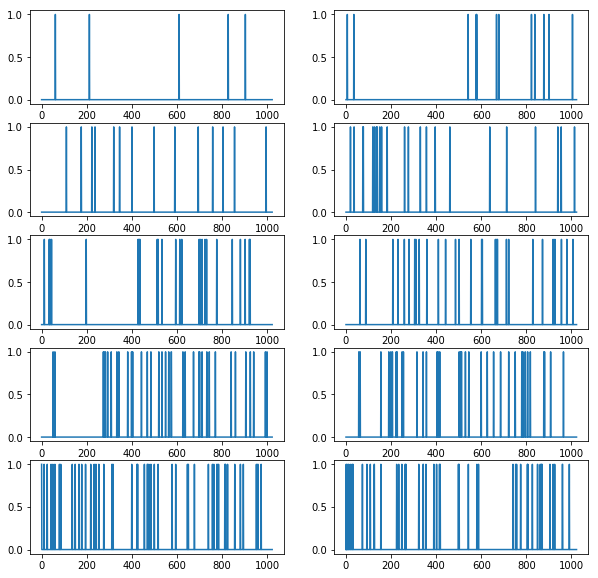

In [3]:
# plot samples from ten different distribution
count = 1
n = 2**10
x_dim = n
t = np.linspace(0, x_dim + 1, x_dim + 1)
mu = 1
fig = plt.figure(figsize = (10,10))
for i in range(10):
    lamb = 0.005 * (i + 1)
    x = sample_compound_poisson(t, lamb,'const',mu)
    dx = np.diff(x)
    plt.subplot(5,2,count)
    plt.plot(dx)
    count += 1

In [4]:
class dcgan(object):
    def __init__(self, sess, count, x_dim, y_dim, x_data, y_data, d_step, g_step, nstep, n_presteps, batch_size = 64, 
                 nepoch = 20, z_dim = 100, gf_dim = 64, df_dim = 64, lr = 1e-3):
        self.x_dim = x_dim
        self.y_dim = y_dim
        self.z_dim = z_dim
        
        self.x_data = x_data
        self.y_data = y_data
        self.count = count
        
        self.sess = sess
        self.batch_size = batch_size
        self.nbatch = len(self.x_data) // self.batch_size  # number of batches in one epoch
        self.nepoch = nepoch
        self.lr = lr
        self.g_step = g_step
        self.d_step = d_step
        self.nstep = nstep  # training steps in one epoch, default should be nbatch
        self.n_presteps = n_presteps
        self.gf_dim = gf_dim
        self.df_dim = df_dim
        
        self.d_score_real_sum = []
        self.d_score_fake_sum = []
        self.g_loss_sum = []
        self.d_loss_sum = []
        
        self.build_model()
        
    def build_model(self):
        self.inputs = tf.placeholder(tf.float32, [self.batch_size, self.x_dim])
        self.y = tf.placeholder(tf.float32, [self.batch_size, self.y_dim])
        self.z = tf.placeholder(tf.float32, [self.batch_size, self.z_dim])
        self.keep_prob = tf.placeholder(tf.float32)
        
        self.G = self.generator(self.z, self.y, self.keep_prob) # fake data
        self.D_logit, self.D = self.discriminator(self.inputs, self.y, self.keep_prob, reuse = False) # prob of true data
        self.D_logit_, self.D_ = self.discriminator(self.G, self.y, self.keep_prob, reuse = True) # prob of fake data
        
        def sigmoid_cross_entropy_with_logits(x, y):
            return tf.nn.sigmoid_cross_entropy_with_logits(logits = x, labels = y)
        
        self.d_real_loss = tf.reduce_mean(
            sigmoid_cross_entropy_with_logits(self.D_logit, tf.ones_like(self.D)))
        self.d_fake_loss = tf.reduce_mean(
            sigmoid_cross_entropy_with_logits(self.D_logit_, tf.zeros_like(self.D)))
        self.g_loss = tf.reduce_mean(
            sigmoid_cross_entropy_with_logits(self.D_logit_, tf.ones_like(self.D_)))
        self.d_loss = self.d_real_loss + self.d_fake_loss
        
        
    def train(self):
        d_optim = tf.train.AdamOptimizer(self.lr).minimize(self.d_loss)
        g_optim = tf.train.AdamOptimizer(self.lr).minimize(self.g_loss)
        
        init = tf.global_variables_initializer() # initialize
        self.sess.run(init)
#         sample_z = np.random.uniform(-1, 1, size=(self.sample_num , self.z_dim))
#         sample_inputs = self.x_data[0:self.sample_num]
#         sample_sx = self.sx_data[0:self.sample_num]
        self.saver = tf.train.Saver()
        
        # pretraining
        for idx in range(self.n_presteps):
            batch_inputs = self.x_data[idx*self.batch_size:(idx+1)*self.batch_size]
            batch_y = self.y_data[idx*self.batch_size:(idx+1)*self.batch_size]
            batch_z = np.random.uniform(-1, 1, [self.batch_size, self.z_dim]).astype(np.float32)
            self.sess.run(d_optim, feed_dict = {
                self.inputs: batch_inputs,
                self.y: batch_y,
                self.z: batch_z,
                self.keep_prob: 0.7
            })
        for epoch in range(self.nepoch):
            for idx in range(self.nstep):
                batch_inputs = self.x_data[idx*self.batch_size:(idx+1)*self.batch_size]
                batch_y = self.y_data[idx*self.batch_size:(idx+1)*self.batch_size]
                
                batch_z = np.random.uniform(-1, 1, [self.batch_size, self.z_dim]).astype(np.float32)
                
                for i in range(self.d_step):
#                     _, errD = self.sess.run([d_optim, self.d_loss], feed_dict = {
                    _ = self.sess.run(d_optim, feed_dict = {
                        self.inputs: batch_inputs,
                        self.y: batch_y,
                        self.z: batch_z,
                        self.keep_prob: 0.7
                    })
                for i in range(self.g_step):
#                     _, errG = self.sess.run([g_optim, self.g_loss], feed_dict = {
                    _ = self.sess.run(g_optim, feed_dict = {
                        self.y: batch_y,
                        self.z: batch_z,
                        self.keep_prob: 0.7
                    })
                
                score_fake = tf.reduce_mean(self.D_).eval({
                    self.z: batch_z, 
                    self.y: batch_y,
                    self.keep_prob: 1.0
                })
            
                score_real = tf.reduce_mean(self.D).eval({
                    self.inputs: batch_inputs,
                    self.y: batch_y,
                    self.keep_prob: 1.0
                })
                errG = self.g_loss.eval({
                    self.z: batch_z,
                    self.y: batch_y,
                    self.keep_prob: 1.0
                })
                errD = self.d_loss.eval({
                    self.inputs: batch_inputs,
                    self.z: batch_z,
                    self.y: batch_y,
                    self.keep_prob: 1.0
                })
                
                self.d_score_fake_sum.append(score_fake)
                self.d_score_real_sum.append(score_real)
                self.g_loss_sum.append(errG)
                self.d_loss_sum.append(errD)
                
                if idx % 20 == 0:
                    self.plot_dist(idx)
                    print("Epoch: %2d, Iter: %2d, d_loss: %.8f, g_loss:%.8f" % (epoch, idx, errD, errG))
#         self.saver.save(self.sess, './result/gan_syn_%2d_%2d.ckpt'%(self.n_presteps//50, self.count))
#         np.save('./result/gan_syn_%2d_%2d_g_loss.ckpt'%(self.n_presteps//50, self.count), np.array(self.g_loss_sum))
        
    def plot_dist(self,idx):
        fig = plt.figure(figsize = (10,7))
        font = {'size':20}
        ax1 = fig.add_subplot(212)
        self.sample_z = np.random.uniform(-1, 1, [self.batch_size , self.z_dim]).astype(np.float32)
        self.sample_y = self.y_data[idx*self.batch_size:(idx + 1)*self.batch_size]
        
        self.sample = self.G.eval({
                    self.z: self.sample_z,
                    self.y: self.sample_y,
                    self.keep_prob: 1.0
                })
        ax1.plot(np.asarray(self.sample[0].squeeze().data))
#         plt.show()
        
        ax2 = fig.add_subplot(221)
        ax2.plot(np.arange(idx+1), np.array(self.d_loss_sum), label='dis loss')
        ax2.plot(np.arange(idx+1), np.array(self.g_loss_sum), label='gen loss')
        ax2.set_title('GAN Loss',font)
        ax2.set_xlabel('Iterations',font)
        ax2.set_ylabel('Loss',font)
        ax2.legend()
        
        ax3 = fig.add_subplot(222)
        ax3.plot(np.arange(idx+1), np.array(self.d_score_real_sum), label='real score')
        ax3.plot(np.arange(idx+1), np.array(self.d_score_fake_sum), label='fake score')
        ax3.set_title('GAN Scores',font)
        ax3.set_xlabel('Iterations',font)
        ax3.set_ylabel('Score',font)
        ax3.legend()
#         plt.tight_layout()
        
        display.clear_output(wait=True)
        display.display(plt.gcf())

        time.sleep(1)
    def conv_concat(self, x, y):
        x_shape = x.get_shape()
        y_shape = y.get_shape()
        return tf.concat([x, y*tf.ones([x_shape[0], x_shape[1], y_shape[2]])], axis = 2)
        
    def discriminator(self, inputs, y, keep_prob, reuse = False):
        with tf.variable_scope('Discriminator', reuse = reuse) as scope:
            if reuse:
                scope.reuse_variables()
            y_ = tf.reshape(y, [self.batch_size, 1, -1])
            x = tf.reshape(inputs, [-1, self.x_dim, 1])

            x = self.conv_concat(x, y_, )
            x = tf.layers.conv1d(x, self.df_dim, 5, padding = 'same', name = 'd_conv_1')
            x = tf.nn.tanh(x)
            x = tf.layers.average_pooling1d(x, 2, 2)

            x = self.conv_concat(x, y_)
            x = tf.layers.conv1d(x, 2*self.df_dim, 5, padding = 'same', name = 'd_conv_2')
            x = tf.nn.tanh(x)
            x = tf.layers.average_pooling1d(x, 2, 2)

            x = tf.contrib.layers.flatten(x)
            x = tf.layers.dense(x, 1024, name = 'd_l_1')
            x = tf.nn.tanh(x)
            x = tf.nn.dropout(x, keep_prob)
            
            x = tf.layers.dense(x, 1, name = 'd_l_2')
            
        return x, tf.nn.sigmoid(x)

    def generator(self, inputz, y, keep_prob, reuse = False):
        with tf.variable_scope('Generator', reuse = reuse):

            x = tf.concat([inputz, y], 1)
            x = tf.layers.dense(x, 1024, name = 'g_l_1')

            x = tf.concat([x, y], 1)
            x = tf.layers.dense(x, (self.x_dim * self.gf_dim // 2), name = 'g_l_2')
            x = tf.nn.dropout(x, keep_prob)
            x = tf.nn.relu(x)

            x = tf.reshape(x, [-1, self.x_dim // 4, 1, 2 * self.gf_dim])
            x = tf.layers.conv2d_transpose(x, self.gf_dim, kernel_size = [5, 1], strides = [2, 1], 
                                           padding = 'same', name = 'g_deconv_1')
            x = tf.nn.relu(x)

            x = tf.layers.conv2d_transpose(x, 1, kernel_size = [5, 1], strides = [2, 1], 
                                           padding = 'same', name = 'g_deconv_2')
            x = tf.nn.relu(x)
            x = tf.reshape(x, [-1, self.x_dim], name = 'output')

            return x

In [5]:
# # compute mean and standard deviation of scattering coefficients in each class
# mu = np.zeros((10, sx_data.shape[1]))
# sigma = np.zeros(mu.shape)
# sx_data_bar = sx_data
# for i in range(10):
#     idx = np.where(y_data[:,i] == 1)[0]
#     mu[i,:] = np.mean(sx_data[idx,:], axis = 0)
#     sigma[i,:] = np.sqrt(np.mean((sx_data[idx, :] - mu[i,:])**2, axis = 0))
#     sx_data_bar[idx,:] = np.ones((len(idx), 1)) * mu[i,:]

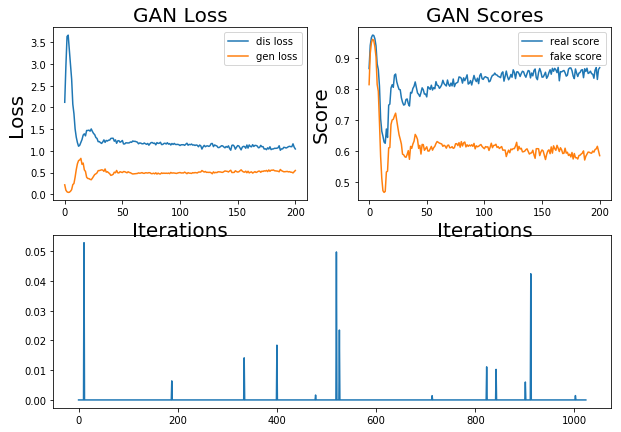

Epoch:  0, Iter: 200, d_loss: 1.04360247, g_loss:0.54668683


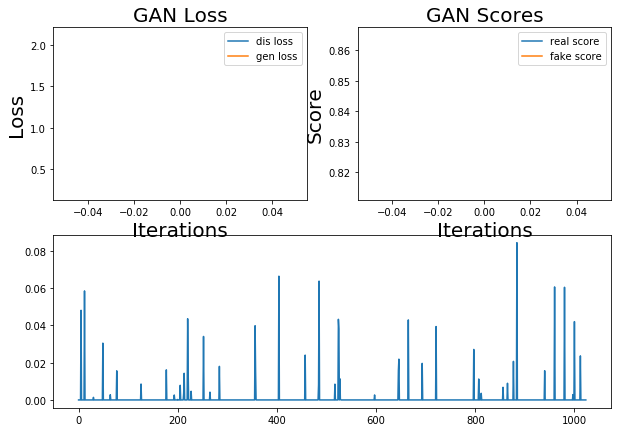

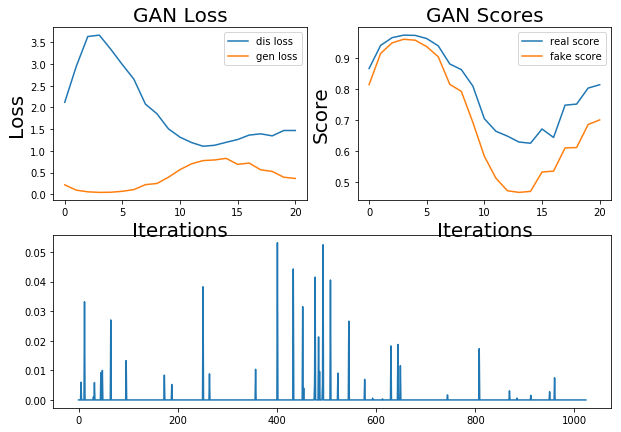

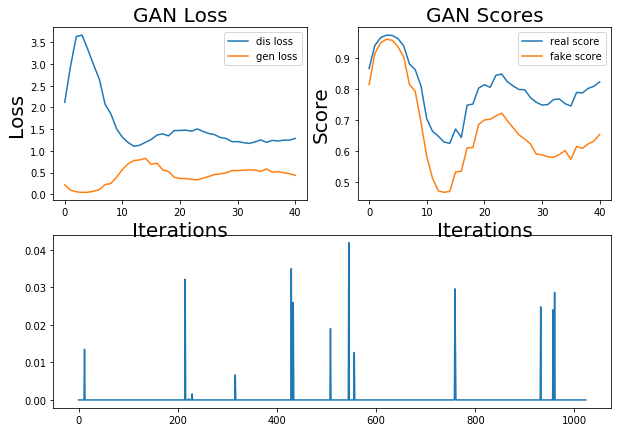

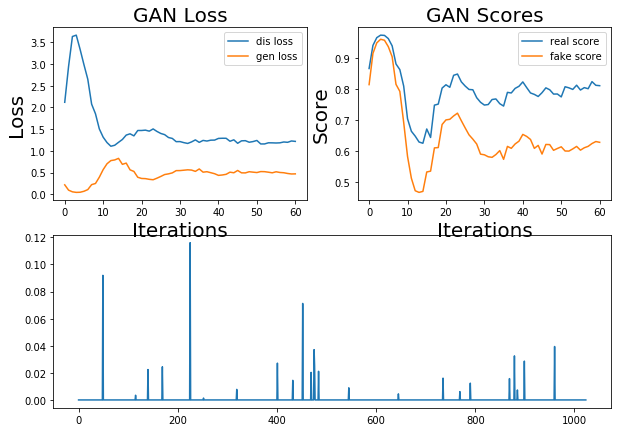

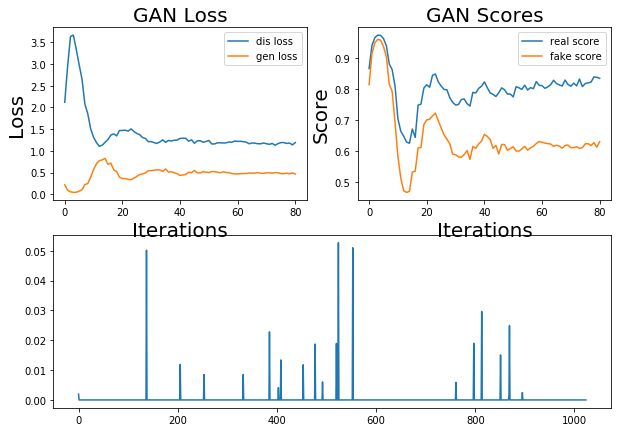

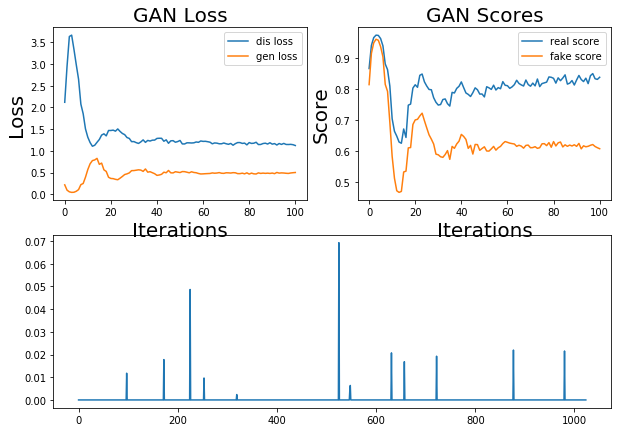

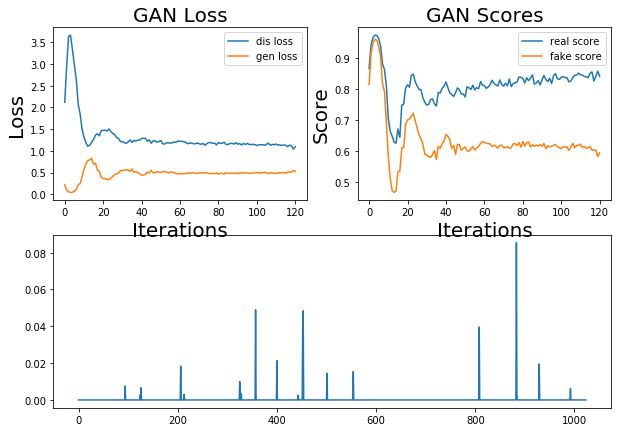

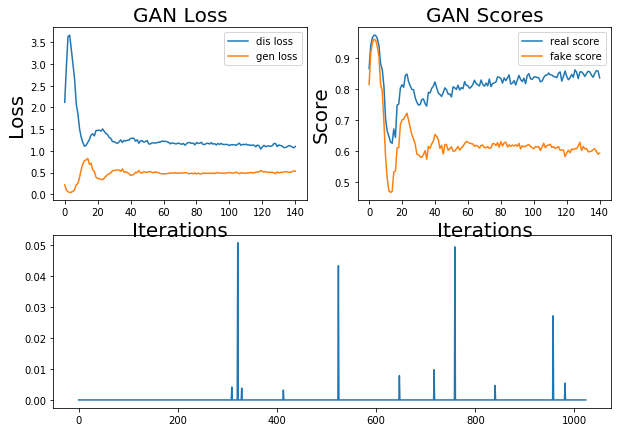

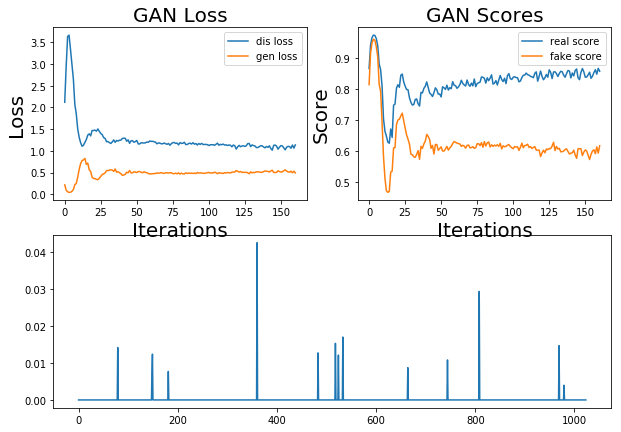

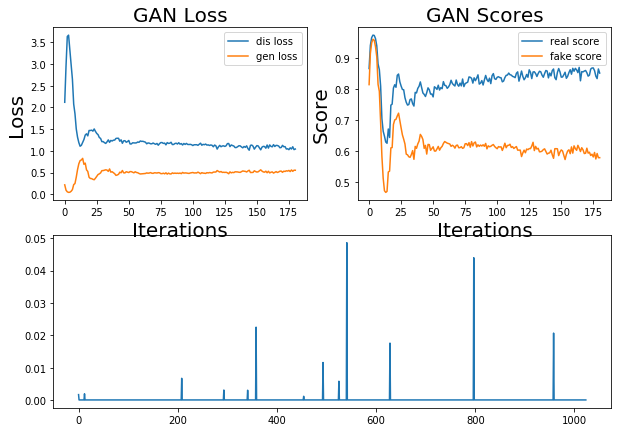

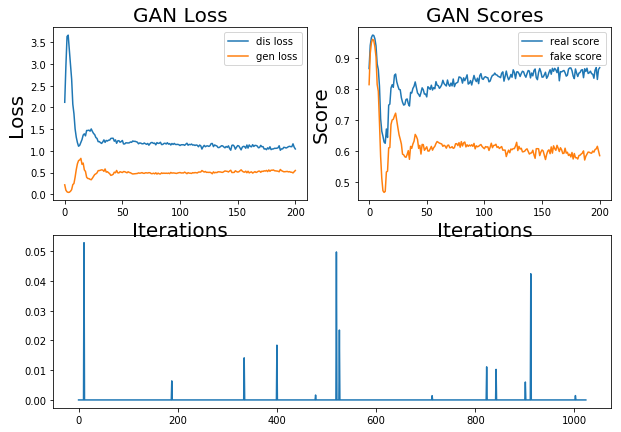

In [7]:
count = 1
d_step = 1
g_step = 1
n_presteps = 50
nstep = 201
tf.reset_default_graph()
# import pickle
with tf.Session() as sess:
    model = dcgan(sess = sess, 
                  count = count,
                  x_dim = x_data.shape[1], 
                  y_dim = y_data.shape[1], 
                  x_data = x_data, 
                  y_data = y_data,
                  d_step = d_step,
                  g_step = g_step,
                  nstep = nstep,
                  n_presteps = n_presteps,
                  batch_size = 64, 
                  nepoch = 1, 
                  z_dim = 100, 
                  gf_dim = 16, 
                  df_dim = 16, 
                  lr = 1e-4)
    model.train()
#     file = open('model.obj', 'w')
#     pickle.dump(model, file )
    count += 1

In [8]:
# # tune parameters
# for n_presteps in [50, 100, 150, 200]:
#     count = 1
#     for (d_step, g_step) in [(1,1), (2,1), (1,2), (3,1), (1,3), (4,1), (1,4), (5,1), (1,5)]:
#         tf.reset_default_graph()
#         with tf.Session() as sess:
#             model = dcgan(sess = sess, 
#                           count = count,
#                           x_dim = x_data.shape[1], 
#                           y_dim = y_data.shape[1], 
#                           x_data = x_data, 
#                           y_data = y_data,
#                           d_step = d_step,
#                           g_step = g_step,
#                           nstep = 101,
#                           n_presteps = n_presteps,
#                           batch_size = 64, 
#                           nepoch = 1, 
#                           z_dim = 100, 
#                           gf_dim = 16, 
#                           df_dim = 16, 
#                           lr = 1e-4)
#             model.train()
#             count += 1

In [9]:
# with tf.Session() as sess:
#     model = dcgan(sess = sess, 
#                   count = count,
#                   x_dim = x_data.shape[1], 
#                   y_dim = y_data.shape[1], 
#                   x_data = x_data, 
#                   y_data = y_data,
#                   d_step = d_step,
#                   g_step = g_step,
#                   nstep = 21,
#                   n_presteps = n_presteps,
#                   batch_size = 64, 
#                   nepoch = 1, 
#                   z_dim = 100, 
#                   gf_dim = 16, 
#                   df_dim = 16, 
#                   lr = 1e-4)
#     saver = tf.train.import_meta_graph('./result/gan_syn_ 0_ 1.ckpt.meta')
#     saver.restore(sess, './result/gan_syn_ 0_ 1.ckpt.meta')
#     graph = tf.get_default_graph()
#     output = graph.get_tensor_by_name('output')

In [64]:
label = model.sample_y
sample = model.sample
count = 0
fig = plt.figure(figsize = (20,16))
for i in range(8):
    for j in range(8):
        plt.subplot(8,8,count + 1)
        plt.plot(sample[count, :])
        plt.title('lambda = ' + str(0.01 * np.where(label[count, :] == 1)[0][0]))
        count += 1
#         frame1 = plt.gca()
#         frame1.axes.get_xaxis().set_visible(False)
#         frame1.axes.get_yaxis().set_visible(False)

In [25]:
2**15

32768